In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import numba as nb

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.utils import shuffle


from xgboost import XGBClassifier

from glob import glob
from tqdm import tqdm
import itertools 
import time

from typing import Optional, List, Union
import logging
from IPython.utils import io

From https://www.youtube.com/watch?v=ovB0ddFtzzA&ab_channel=mildlyoverfitted

# **Pytorch Transformer network**

In [3]:
class MZSequenceEmbed(nn.Module):
    """Split image into mz sequences and embed them.
    Parameters
    ----------
    sequence_length : int
        Number of temperature bins.
    in_chans : int
        Number of input channels. 
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, sequence_length, in_chans=1, embed_dim=10):
        super().__init__()

        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=(sequence_length, 1),
                stride=(sequence_length, 1),
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, sequnce_length, mz_number)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, mz_number, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, 1, mz_number)
        x = torch.squeeze(x)  # (n_samples, embed_dim, mz_number)
        x = x.transpose(1, 2)  # (n_samples, mz_number, embed_dim)

        return x

In [4]:
class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x

In [5]:
class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class SpectroTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    sequnce_length : int
        Number of temperature bins.
    mz_number : int
        Number of m/z values.
    in_chans : int
        Number of input channels. 

        
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).

    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    mz_seq_embed : MZSequenceEmbed
        Instance of `MZSequenceEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            sequence_length,
            mz_number,
            in_chans=1,
            n_classes=1000,
            embed_dim=768,
            depth=2,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.mz_seq_embed = MZSequenceEmbed(
            sequence_length=sequence_length,
            in_chans=in_chans,
            embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + mz_number, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.mz_seq_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

# **Load and proprocess data**

## Functions

In [6]:
@nb.jit(nopython=True)
def array_to_square_array(x, col):
    col_values = np.unique(x[:,col])
    new_array = [[[0.] for j in range(x.shape[1])] for i in col_values]
    col_counts = [0 for i in col_values]
    max_count = 0
    
    for i in range(x.shape[0]):
        row = x[i]
        
        col_index = np.argwhere(col_values==row[col]).item()
        col_counts[col_index] += 1
        
        for n in range(max_count - col_counts[col_index]):
            for j in range(len(row)):
                new_array[col_index][j].append(np.nan)
            col_counts[col_index] += 1
        
        for j in range(len(row)):
            new_array[col_index][j].append(row[j])

        max_count = max(max_count, col_counts[col_index])
    
    for col_index in range(len(col_values)):
        for n in range(max_count - col_counts[col_index]):
            for j in range(len(row)):
                new_array[col_index][j].append(np.nan)
    return np.array(new_array)[...,1:], col_values

# array_to_square_array(df[:10].values, 2)[0].shape

In [7]:
def reshape_df_to_ds(df):
    ds_sample_parts = []
    
    x, mz = array_to_square_array(df.values, 2)
    
    ts = np.nanmean(x[:,0,:], axis=0)
    temps = np.nanmean(x[:,1,:], axis=0)
    abunds = x[:,3,:]
    index = np.arange(x.shape[-1])
    
    ds_new = xr.DataArray(abunds, dims=['mz', 'index'], coords=[mz, index], name='abundance').to_dataset()

    ds_new['time'] = xr.DataArray(ts, dims=['index'], coords=[ds_new.index.values], name='time')
    ds_new['temp'] = xr.DataArray(temps, dims=['index'], coords=[ds_new.index.values], name='temp')
    return ds_new

In [8]:
def get_he(ds):
    if 4 in ds.mz:
        return np.clip(ds.sel(mz=4).abundance.mean(dim=('index')).item(), 0, 4e-7)
    else:
        return np.nan
    
def get_max(ds):
    return np.clip(ds.abundance.mean(dim=('index')).max(dim='mz').item(), 0, 4e-7)

In [12]:
def copy_raw_abundance(ds):
    ds['raw_abundance'] = ds.abundance.copy()
    return ds

def fix_offset_abundance(ds):
    ds['abundance'] = ds.abundance - ds.abundance.min(dim='mz')
    return ds

def min_max_scale_sample(ds):
    ds['abundance'] = ds.abundance/ds.abundance.max(dim=('mz', 'index')) #.mean(dim='index').max(dim='mz')#
    return ds

def scale_by_helium_sample(ds):
    ds['abundance'] = ds.abundance/ds.abundance.sel(mz=4).max(dim=('index'))
    return ds

In [10]:
@nb.jit(nopython=True)
def round_discard(x, fill=-1, tol=.2):
    l = [0]
    for v in x:
        if ((v<int(v)-v)>tol) and (int(v+tol)!=(int(v)+1)):
            l.append(int(fill))
        else:
            l.append(int(v+tol))
    return np.array(l)[1:]

def drop_frac_mz_with_rounding(ds, fill=-1, tol=.2):
    g = xr.DataArray(round_discard(ds.mz.values, fill=fill, tol=tol), dims=['mz'], coords=[ds.mz], name='g')
    ds = ds.groupby(g).sum(dim='mz').rename({'g':'mz'})
    ds['temp'] = ds.temp.isel(mz=0).drop('mz')
    ds['time'] = ds.time.isel(mz=0).drop('mz')
    return ds

def drop_helium(ds):
    return ds.sel(mz=[x for x in ds.mz if x!=4])

def drop_heavy(ds, mz_thresh=100):
    return ds.sel(mz=slice(None, mz_thresh))

round_discard(np.random.normal(0,1,100))

array([-1, -1,  0,  0,  0,  1, -1,  0, -1, -1, -1,  1, -1,  0, -1,  1, -1,
       -1,  0, -1,  1,  0,  1,  0, -1, -1, -1,  1,  0,  1,  0,  0,  0,  1,
        0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  1,  0, -1, -1, -1, -1,  0,
       -1, -1,  0,  1, -1,  0,  0, -1, -1, -1,  0, -1,  1, -1,  0, -1,  0,
       -1,  0, -1,  1,  0,  0, -1,  0, -1,  0,  0,  1, -1,  0, -1,  1,  1,
       -1, -1,  0, -1, -1, -1,  0,  1,  1, -1, -1,  0, -1,  1, -1])

In [13]:
def preprocess(ds):
    ds = copy_raw_abundance(ds)
    ds = drop_frac_mz_with_rounding(ds)
    #ds = drop_helium(ds)
    ds = drop_heavy(ds, mz_thresh=100)
    ds = fix_offset_abundance(ds)
    ds = min_max_scale_sample(ds)
    return ds

def preprocess2(ds):
    
    ds = drop_frac_mz_with_rounding(ds)
    ds = drop_heavy(ds, mz_thresh=100)
    ds = fix_offset_abundance(ds)
    ds = scale_by_helium_sample(ds)
    ds = drop_helium(ds)
    return ds

In [14]:
def append_labels_and_meta(ds):
    labels = (
        pd.read_csv("../data/train_labels.csv")
        .set_index('sample_id', drop=True)
        .to_xarray()
        .to_array(dim='species', name='labels')
    ).transpose()

    metadata = (
        pd.read_csv("../data/metadata.csv")
        .set_index('sample_id', drop=True)
        .to_xarray()
        .drop(['features_path', 'features_md5_hash'])
    )

    ds = ds.merge(labels).merge(metadata)
    return ds

In [15]:
def bin_by_temp(ds, bins):
    return ds.groupby_bins('temp', bins).mean(dim='index')

In [16]:
def bin_along_temp(all_ds, bins):
    all_ds = [bin_by_temp(ds, bins) for ds in tqdm(all_ds)]
    ds_regrid = xr.concat(all_ds, dim='sample_id')
    ds_regrid['features'] = ds_regrid.abundance#/ds_mx_regrid.abundance.max(dim='mz')).clip(0,1)
    ds_regrid['features'] = ds_regrid.features.fillna(-.1)
    ds_regrid = append_labels_and_meta(ds_regrid)
    return ds_regrid

## Process data

### Load and reshape raw data

In [17]:
all_ds_raw = []

files = sorted(
    glob("../data/train_features/*.csv") +
    glob("../data/val_features/*.csv") +
    glob("../data/test_features/*.csv"),
    key = lambda x: x.split('/')[-1]
)

for f in tqdm(files):
    # topu
    df = pd.read_csv(f)
    sample_id = f.split('/')[-1].replace('.csv', '')
    
    ds_new = reshape_df_to_ds(df)
    ds_new = ds_new.assign_coords({"sample_id": [sample_id]})
    
    all_ds_raw.append(ds_new)

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [01:37<00:00, 16.17it/s]


(array([118.,  44.,  22.,  65., 133., 149., 122., 134., 197., 168.,  53.,
         28.,  14.,   3.,   0.,   1.,   2.,   4.,   7.,  14.,   8.,  14.,
         21.,   9.,   2.,  11.,   6.,  13.,  11., 197.]),
 array([1.85974829e-13, 1.33335131e-08, 2.66668402e-08, 4.00001674e-08,
        5.33334945e-08, 6.66668216e-08, 8.00001488e-08, 9.33334759e-08,
        1.06666803e-07, 1.20000130e-07, 1.33333457e-07, 1.46666784e-07,
        1.60000112e-07, 1.73333439e-07, 1.86666766e-07, 2.00000093e-07,
        2.13333420e-07, 2.26666747e-07, 2.40000074e-07, 2.53333402e-07,
        2.66666729e-07, 2.80000056e-07, 2.93333383e-07, 3.06666710e-07,
        3.20000037e-07, 3.33333364e-07, 3.46666691e-07, 3.60000019e-07,
        3.73333346e-07, 3.86666673e-07, 4.00000000e-07]),
 <BarContainer object of 30 artists>)

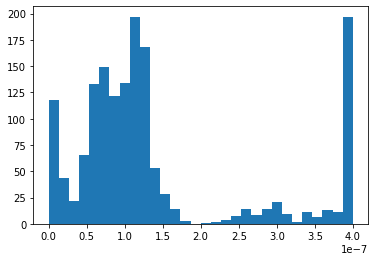

In [18]:
plt.hist([get_max(ds) for ds in all_ds_raw], bins=30)

In [19]:
all_ds = [preprocess(ds) for ds in tqdm(all_ds_raw)]

100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [02:53<00:00,  9.07it/s]


In [17]:
all_ds[0]

<xarray.Dataset>
Dimensions:    (index: 193, mz: 101, sample_id: 1)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 ... 185 186 187 188 189 190 191 192
  * sample_id  (sample_id) <U5 'S0000'
  * mz         (mz) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
Data variables:
    abundance  (mz, index) float64 0.001541 0.001549 0.001527 ... 0.0 0.0 0.0
    time       (index) float64 0.0 10.25 20.52 ... 1.951e+03 1.961e+03 1.972e+03
    temp       (index) float64 35.29 35.42 35.68 36.33 ... 366.9 368.6 370.4

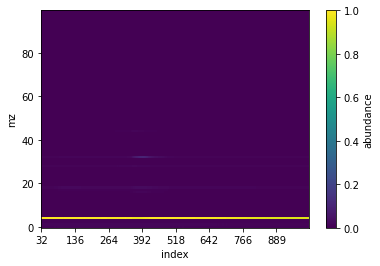

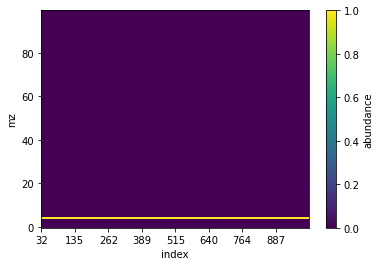

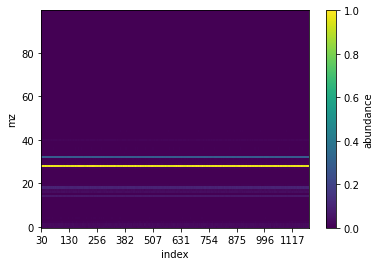

In [18]:
for i in range(50, 80, 10):
    all_ds[i].abundance.plot()
    ticks = all_ds[i].index[::40].values
    labels = np.round(all_ds[i].temp)[::40].values.astype(int)
    plt.xticks(ticks=ticks, labels=labels)
    plt.show()

### Bin data along new temp dimension

In [20]:
bins = np.arange(0, 1300, 20)
print(bins.shape)
ds_bin = bin_along_temp(all_ds, bins=bins)

(65,)


100%|███████████████████████████████████████████████████████████████████████████████| 1570/1570 [01:47<00:00, 14.58it/s]


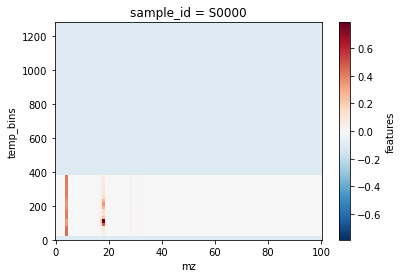

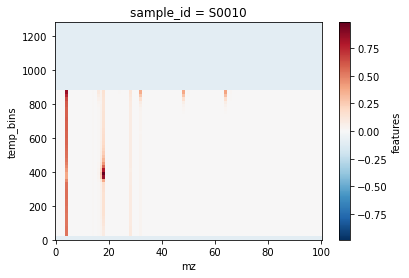

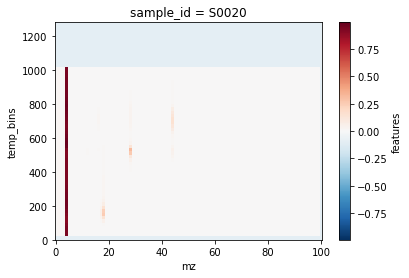

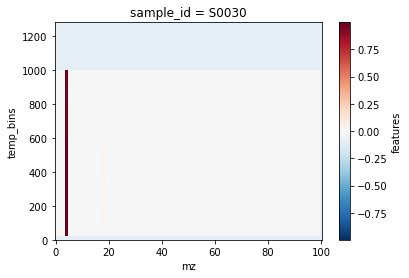

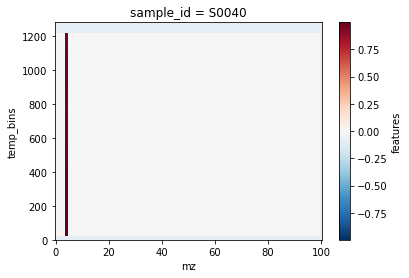

In [21]:
for i in range(0, 50, 10):
    ds_bin.features.isel(sample_id=i).plot()
    plt.show()

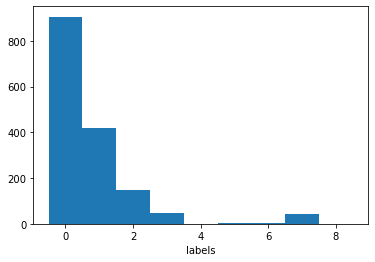

In [58]:
clip_n=9
ds_bin.labels.sum(dim='species').clip(0, clip_n).plot.hist(bins = np.arange(0,clip_n+1)-.5)
plt.show()

In [72]:
ds_bin

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 101, temp_bins: 64, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    time             (sample_id, temp_bins) float64 nan 30.78 123.1 ... nan nan
    temp             (sample_id, temp_bins) float64 nan 36.92 49.9 ... nan nan
    raw_abundance    (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    features         (sample_id, temp_bins, mz) float64 -0.1 -0.1 ... -0.1 -0.1
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [119]:
ds_bin.where(ds_bin.split=='train').groupby('instrument_type').count()

<xarray.Dataset>
Dimensions:          (instrument_type: 2, temp_bins: 64, mz: 101, species: 10)
Coordinates:
  * instrument_type  (instrument_type) object 'commercial' 'sam_testbed'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (instrument_type, temp_bins, mz) int64 0 27 28 27 ... 0 0 0
    time             (instrument_type, temp_bins) int64 28 704 705 751 ... 0 0 0
    temp             (instrument_type, temp_bins) int64 28 704 705 751 ... 0 0 0
    raw_abundance    (instrument_type, temp_bins, mz) int64 0 27 28 27 ... 0 0 0
    features         (instrument_type, temp_bins, mz) int64 754 754 ... 12 12
    labels           (instrument_type, species) int64 754 754 754 ... 12 12 12
    split            (instrument_type) int64 754 12

In [118]:
ds_bin.where(ds_bin.split=='train').groupby('instrument_type').sum().labels

<xarray.DataArray 'labels' (instrument_type: 2, species: 10)>
array([[ 91.,  97.,  93., 169.,  30., 179., 242., 104., 148.,  36.],
       [  0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.]])
Coordinates:
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
  * instrument_type  (instrument_type) object 'commercial' 'sam_testbed'

In [124]:
species_positive = ds_bin.where(
    (ds_bin.labels.sel(species='carbonate'))==1, #+
    #ds_bin.labels.sum(dim='species')>0)==2,
    drop=True)

In [125]:
species_positive

<xarray.Dataset>
Dimensions:          (sample_id: 98, temp_bins: 64, mz: 101, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0001' 'S0003' ... 'S0747' 'S0755'
  * mz               (mz) int64 0 1 2 3 4 5 6 7 8 ... 93 94 95 96 97 98 99 100
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan 0.0005872 ... nan
    time             (sample_id, temp_bins) float64 805.6 865.8 ... nan nan
    temp             (sample_id, temp_bins) float64 11.03 31.22 ... nan nan
    raw_abundance    (sample_id, temp_bins, mz) float64 nan 5.334e-10 ... nan
    features         (sample_id, temp_bins, mz) float64 -0.1 0.0005872 ... -0.1
    labels           (sample_id, species) float64 0.0 1.0 0.0 ... 0.0 1.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [131]:
        species_positive.features\
            .where(ds_bin.instrument_type==s, drop=True) \
            .where(species_positive.features!=-.1) \
            .isel(sample_id=slice(0,n)) \

<xarray.DataArray 'features' (sample_id: 1, temp_bins: 64, mz: 101)>
array([[[       nan, 0.00058721, 0.03593509, ...,        nan,
                nan,        nan],
        [       nan, 0.00058653, 0.03634694, ...,        nan,
                nan,        nan],
        [       nan, 0.00061336, 0.03653861, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * sample_id  (sample_id) object 'S0001'
  * mz         (mz) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * temp_bins  (temp_bins) object (0, 20] (20, 40] ... (1240, 1260] (1260, 1280]

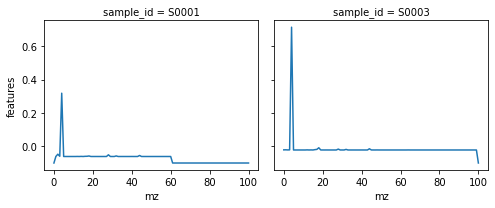

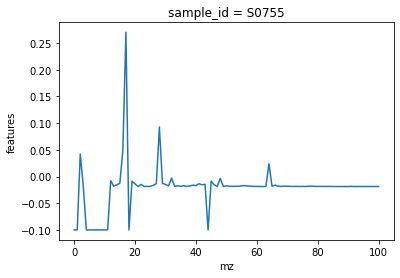

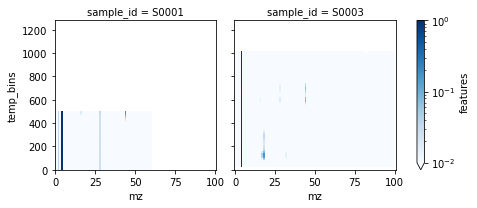

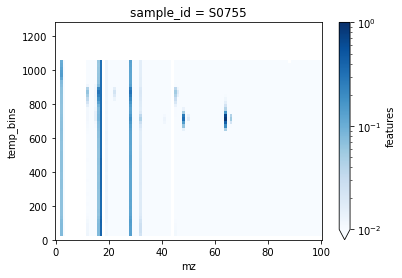

In [145]:
import matplotlib.colors as colors
norm=colors.LogNorm(vmin=.01, vmax=1)

n=2
#norm=colors.Normalize(vmin=.01, vmax=1)
for s in np.unique(ds_bin.instrument_type):
    x = species_positive.features\
            .where(ds_bin.instrument_type==s, drop=True) \
            .isel(sample_id=slice(0,n)) \
            .mean(dim='temp_bins')
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot()
    else:
        x.plot(col="sample_id")#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()

for s in np.unique(ds_bin.instrument_type):
    x = species_positive.features\
        .where(ds_bin.instrument_type==s, drop=True) \
        .where(species_positive.features!=-.1) \
        .isel(sample_id=slice(0,n))
    
    if len(x.sample_id)==0:
        continue
    elif len(x.sample_id)==1:
        x.plot(norm=norm, cmap='Blues')
    else:
        x.plot(col="sample_id", norm=norm, cmap='Blues')#, col_wrap=4)#, norm=norm, cmap='Blues')            
    plt.show()


### Filter to m/z with larger magnitudes

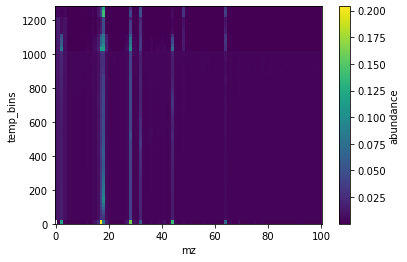

In [21]:
x = ds_bin.abundance.mean(dim=('sample_id')).drop_sel(mz=4)
#x = x / x.max(dim='temp_bins')
x.plot()

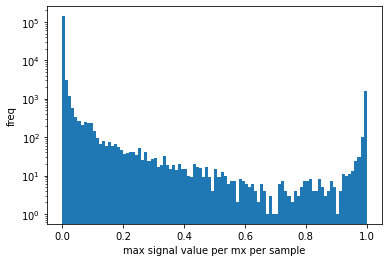

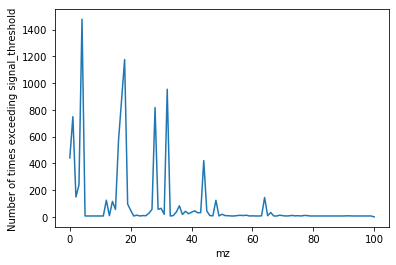

Number of mz with signal_threshold=0.01 and occurence_threshold=10 is : 41


In [22]:
(ds_bin.abundance.max(dim=('temp_bins'))).plot.hist(bins=100);
plt.yscale('log')
plt.xlabel('max signal value per mx per sample')
plt.ylabel('freq')
plt.show()

signal_threshold = 0.01
occurence_threshold = 10

x = (ds_bin.abundance.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id')
x.plot()
plt.xlabel('mz')
plt.ylabel(f'Number of times exceeding signal_threshold')
plt.show()
print(f"Number of mz with signal_threshold={signal_threshold} and occurence_threshold={occurence_threshold} is : {(x>occurence_threshold).sum().item()}")

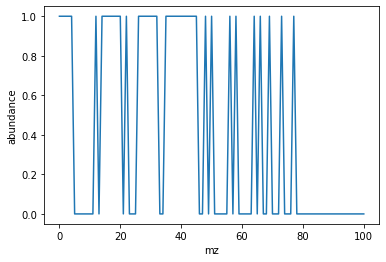

In [23]:
## get rid of mz which don't have strong signal many times
mz_mask = (ds_bin.abundance.max(dim=('temp_bins'))>signal_threshold).sum(dim='sample_id') > occurence_threshold
mz_mask.plot()

In [24]:
ds_bin_filt = ds_bin.sel(mz=mz_mask)
ds_bin_filt

<xarray.Dataset>
Dimensions:          (sample_id: 1570, mz: 41, temp_bins: 64, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S1568' 'S1569'
  * mz               (mz) int64 0 1 2 3 4 12 14 15 ... 50 56 58 64 66 69 73 77
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    time             (sample_id, temp_bins) float64 nan 30.78 123.1 ... nan nan
    temp             (sample_id, temp_bins) float64 nan 36.92 49.9 ... nan nan
    features         (sample_id, temp_bins, mz) float64 -0.1 -0.1 ... -0.1 -0.1
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... nan nan nan
    split            (sample_id) object 'train' 'train' ... 'test' 'test'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

### Final dataset

In [25]:
ds_final = ds_bin_filt.where(ds_bin_filt.split=='train', drop=True)

ds_final

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 64, mz: 41, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz               (mz) int64 0 1 2 3 4 12 14 15 ... 50 56 58 64 66 69 73 77
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    time             (sample_id, temp_bins) float64 nan 30.78 123.1 ... nan nan
    temp             (sample_id, temp_bins) float64 nan 36.92 49.9 ... nan nan
    features         (sample_id, temp_bins, mz) float64 -0.1 -0.1 ... -0.1 -0.1
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

## Analysis

In [ ]:
ds_final.max()

# **Lightning modules**

## Transformer

In [26]:
class SpectroTransformerLightning(pl.LightningModule):
    def __init__(
        self,
        hparams: dict = {},
    ):

        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # optional modeling params
        #self.learning_rate = self.hparams.get("lr", 1e-3)
        self.patience = self.hparams.get("patience", 5)
        
        self.model = self._prepare_model()
        self.seed = self.hparams.get("seed", 0)
        
        self.loss_fn = nn.BCEWithLogitsLoss()
        
    
    def forward(self, image: torch.Tensor):
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.
        """

        # Load images and labels
        x, y = batch

        # Forward pass
        preds = self.forward(x)

        # Log batch loss
        loss = self.loss_fn(preds, y)
                
        self.log("training_loss", loss, on_epoch=True, on_step=False)
            
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.
        """
        
        # Load images and labels
        x, y = batch

        # Forward pass & softmax
        preds = self.forward(x)

        # Log batch IOU
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss) # mean automatically taken over validation set 

        return


    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.model.parameters(), lr=self.hparams["lr"], amsgrad=True)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
            factor=0.5,
            patience=self.patience,
            threshold=2e-4,
            cooldown=self.patience//2,                                   
        )
        sch = {"scheduler": sch, "monitor": "training_loss"}
        return [opt], [sch]
        

    def _prepare_model(self):
        model = SpectroTransformer(
            sequence_length=self.hparams.get("sequence_length", None), # len(ds_train.temp_bins),
            mz_number=self.hparams.get("mz_number", None), #len(ds_train.mz),
            in_chans=1,
            n_classes=self.hparams.get("n_classes", None), # len(ds_train.species),
            embed_dim=64,
            depth=1,
            n_heads=16,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.0,
            attn_p=0.0,
        )
        return model

## Dataset

In [27]:
class SpectroDataset(Dataset):
    
    def __init__(self, ds, augmentation=None):
        self.ds = ds
        self.augmentation = augmentation
    
    def __len__(self):
        return self.ds.sample_id.shape[0]

    def __getitem__(self, idx):
        # need to set single-threaded scheduler so no clash with DataLoader scheduler
        da = self.ds.isel(sample_id=idx)
        image = da.features.values[None]
        label = da.labels.values
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        if self.augmentation:
            image = self.augmentation(image)
        return image, label

In [28]:
class SpectroDataModule(pl.LightningDataModule):
    def __init__(self, ds, ds_val=None, **kwargs):
        super().__init__()
        
        self.num_workers = kwargs.get("num_workers", 2)
        self.batch_size = kwargs.get("batch_size", 16)
        self.augmentation = kwargs.get("augmentation", None)
    
        if ds_val is None:
            self.val_frac = kwargs.get("val_frac", 0.2)
            self.data_split_seed = kwargs.get("data_split_seed", None)
            train_samples, test_samples = train_test_split(self.ds.sample_id.values, random_state=self.data_split_seed)
            self.ds_train = ds.sel(sample_id=train_samples)
            self.ds_val = ds.sel(sample_id=test_samples)
        else:
            self.ds_train = ds
            self.ds_val = ds_val
            self.val_frac = ds_val.sample_id.shape[0]/(ds.sample_id.shape[0]+ds_val.sample_id.shape[0])
            self.data_split_seed = None


    def setup(self, stage: Optional[str] = None):
        # split dataset
        if stage not in (None, "fit"):
            raise NotImplementedError
        
        self.train_dataset = SpectroDataset(
            self.ds_train,
            augmentation=self.augmentation,
        )
        self.val_dataset = SpectroDataset(
            self.ds_val,
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )
    

## Simpler model

In [29]:
class MZSequenceEmbedT(nn.Module):
    """Split image into mz sequences and embed them.
    Parameters
    ----------
    sequence_length : int
        Number of temperature bins.
    in_chans : int
        Number of input channels. 
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, sequence_length, in_chans=1, embed_dim=10):
        super().__init__()

        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=(sequence_length, 1),
                stride=(sequence_length, 1),
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, sequnce_length, mz_number)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, mz_number, embed_dim)`.
        """
        x = self.proj(x)  # (n_samples, embed_dim, 1, mz_number)
        x = torch.squeeze(x)  # (n_samples, embed_dim, mz_number)

        return x
    
class SequenceRefiner(nn.Module):
    def __init__(self, in_chans=10, out_chans=10, depth=1, dropout_p=0):
        super().__init__()
                
        refiner = []
        for i in range(depth):
            refiner += [
                nn.Conv1d(
                        in_chans,
                        in_chans,
                        kernel_size=1
                ),
                nn.BatchNorm1d(in_chans),
                nn.LeakyReLU(),
                nn.Dropout(p=dropout_p),
            ]
            
        self.refiner = nn.Sequential(*refiner)

        self.combiner = nn.Sequential(
            nn.Conv1d(
                in_chans,
                out_chans,
                kernel_size=1
            ),
            nn.BatchNorm1d(out_chans),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p)
        )
            
    def forward(self, x):
        x_resid = x + self.refiner(x)
        x_resid = self.combiner(x_resid)
        return x_resid
    
class SequenceComparer(nn.Module):
    def __init__(self, n_sequences=10, sequence_dim=10, emb_dim=2, dropout_p=0):
        super().__init__()

        self.comparer = nn.Sequential(
            nn.Linear(n_sequences*sequence_dim, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_p)
        )
            
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.comparer(x)
        return x

In [30]:
class simpleModel(nn.Module):
    def __init__(self, 
                 sequence_length, 
                 mz_number, 
                 n_classes, 
                 in_chans=1, 
                 seq_embed_dim=10, 
                 seq_emb_depth=1, 
                 comp_embed_dim=10, 
                 dropout_p=0):
        
        super().__init__()
        assert seq_emb_depth>=1
        
        sequence_embed = MZSequenceEmbedT(sequence_length, in_chans=in_chans, embed_dim=seq_embed_dim)
        
        sequence_refiners = [sequence_embed]
        for i in range(seq_emb_depth-1):
            sequence_refiners += [
                SequenceRefiner(
                    in_chans=seq_embed_dim, 
                    out_chans=seq_embed_dim, 
                    depth=2, 
                    dropout_p=dropout_p,
                )
            ]
            
        self.sequence_refiners = nn.ModuleList(sequence_refiners)
        
        sequence_comparers = []
        for i in range(seq_emb_depth):
            sequence_comparers += [
                SequenceComparer(
                    n_sequences=mz_number, 
                    sequence_dim=seq_embed_dim, 
                    emb_dim=comp_embed_dim, 
                    dropout_p=dropout_p,
                )
            ]
        self.sequence_comparers = nn.ModuleList(sequence_comparers)
        
        self.compare_aggregator = nn.Sequential(
            nn.Linear(seq_emb_depth*comp_embed_dim, n_classes)
        )
    
    def forward(self, x):
        
        comp_emb = []
        for ref, comp in zip(self.sequence_refiners, self.sequence_comparers):
            x = ref(x)
            comp_emb += [comp(x)]
        comp_emb = torch.cat(comp_emb, dim=1)
        return self.compare_aggregator(comp_emb)

In [ ]:

class SimpleModelLightning(SpectroTransformerLightning):

    def _prepare_model(self):
        model = simpleModel(            
            sequence_length=len(ds_train.temp_bins),
            mz_number=len(ds_train.mz),
            n_classes=len(ds_train.species),
            seq_embed_dim=64,
            seq_emb_depth=4,
            comp_embed_dim=16,
            dropout_p=0.1,
            in_chans=1, 
        )
        return model



# **Use transformer network**

## Train

In [363]:
model = SpectroTransformerLightning._prepare_model(SpectroTransformerLightning)
sum([len(l) for l in model.parameters()])

4502

In [364]:
model = SimpleModelLightning._prepare_model(SimpleModelLightning)
sum([len(l) for l in model.parameters()])

2708

In [367]:
model = SpectroTransformerLightning(hparams=dict(lr=1e-3, patience=20))
#model = SimpleModelLightning(hparams=dict(lr=1e-3, patience=20))

datamodule = SpectroDataModule(
    ds_train,
    num_workers=4,
    batch_size=16,
    data_split_seed=34536,
    val_frac=0.1,
)

callbacks = []
callbacks += [ModelCheckpoint(
    monitor="val_loss", 
    mode="min",
    verbose=True,
    save_top_k=1,
    save_last=True,
)]

callbacks += [LearningRateMonitor()]


logger = TensorBoardLogger('../lightning_logs', name='test')

# train
trainer = pl.Trainer(
    gpus=[0],
    fast_dev_run=False,
    log_every_n_steps=50,
    default_root_dir='../.',
    callbacks = callbacks,
    max_epochs=1000,
    logger=logger,
    accumulate_grad_batches=1,
    val_check_interval=1.0,
    reload_dataloaders_every_epoch=True, # to make sure shuffle every epoch
    #precision=16,
)

trainer.fit(model, datamodule=datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type               | Params
-----------------------------------------------
0 | model   | SpectroTransformer | 57.7 K
1 | loss_fn | BCEWithLogitsLoss  | 0     
-----------------------------------------------
57.7 K    Trainable params
0         Non-trainable params
57.7 K    Total params
0.231     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 35: val_loss reached 0.40427 (best 0.40427), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=0-step=35.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 71: val_loss reached 0.40418 (best 0.40418), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=1-step=71.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 107: val_loss reached 0.39564 (best 0.39564), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=2-step=107.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 143: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 179: val_loss reached 0.39373 (best 0.39373), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=4-step=179.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 215: val_loss reached 0.38836 (best 0.38836), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=5-step=215.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 251: val_loss reached 0.37830 (best 0.37830), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=6-step=251.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 287: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 323: val_loss reached 0.35896 (best 0.35896), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=8-step=323.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, global step 359: val_loss reached 0.34075 (best 0.34075), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=9-step=359.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, global step 395: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, global step 431: val_loss reached 0.33673 (best 0.33673), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=11-step=431.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 467: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, global step 503: val_loss reached 0.32722 (best 0.32722), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=13-step=503.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, global step 539: val_loss reached 0.30823 (best 0.30823), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=14-step=539.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 575: val_loss reached 0.30596 (best 0.30596), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=15-step=575.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, global step 611: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, global step 647: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, global step 683: val_loss reached 0.28506 (best 0.28506), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=18-step=683.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, global step 719: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 20, global step 755: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 21, global step 791: val_loss reached 0.27063 (best 0.27063), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=21-step=791.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 22, global step 827: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 23, global step 863: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 24, global step 899: val_loss reached 0.25672 (best 0.25672), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=24-step=899.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 25, global step 935: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 26, global step 971: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 27, global step 1007: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 28, global step 1043: val_loss reached 0.25101 (best 0.25101), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=28-step=1043.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 29, global step 1079: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 30, global step 1115: val_loss reached 0.22178 (best 0.22178), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=30-step=1115.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 31, global step 1151: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 32, global step 1187: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 33, global step 1223: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 34, global step 1259: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 35, global step 1295: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 36, global step 1331: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 37, global step 1367: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 38, global step 1403: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 39, global step 1439: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 40, global step 1475: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 41, global step 1511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 42, global step 1547: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 43, global step 1583: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 44, global step 1619: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 45, global step 1655: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 46, global step 1691: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 47, global step 1727: val_loss reached 0.22031 (best 0.22031), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=47-step=1727.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 48, global step 1763: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 49, global step 1799: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 50, global step 1835: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 51, global step 1871: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 52, global step 1907: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 53, global step 1943: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 54, global step 1979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 55, global step 2015: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 56, global step 2051: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 57, global step 2087: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 58, global step 2123: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 59, global step 2159: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 60, global step 2195: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 61, global step 2231: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 62, global step 2267: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 63, global step 2303: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 64, global step 2339: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 65, global step 2375: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 66, global step 2411: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 67, global step 2447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 68, global step 2483: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 69, global step 2519: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 70, global step 2555: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 71, global step 2591: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 72, global step 2627: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 73, global step 2663: val_loss reached 0.21479 (best 0.21479), saving model to "../lightning_logs/test/version_31/checkpoints/epoch=73-step=2663.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 74, global step 2699: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 75, global step 2735: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 76, global step 2771: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 77, global step 2807: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 78, global step 2843: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 79, global step 2879: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 80, global step 2915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 81, global step 2951: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 82, global step 2987: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 83, global step 3023: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 84, global step 3059: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 85, global step 3095: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 86, global step 3131: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 87, global step 3167: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 88, global step 3203: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 89, global step 3239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 90, global step 3275: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 91, global step 3311: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 92, global step 3347: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 93, global step 3383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 94, global step 3419: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 95, global step 3455: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 96, global step 3491: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 97, global step 3527: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 98, global step 3563: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 99, global step 3599: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 100, global step 3635: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 101, global step 3671: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 102, global step 3707: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 103, global step 3743: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 104, global step 3779: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 105, global step 3815: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 106, global step 3851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 107, global step 3887: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 108, global step 3923: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 109, global step 3959: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 110, global step 3995: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 111, global step 4031: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 112, global step 4067: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 113, global step 4103: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 114, global step 4139: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 115, global step 4175: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 116, global step 4211: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 117, global step 4247: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 118, global step 4283: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 119, global step 4319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 120, global step 4355: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 121, global step 4391: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 122, global step 4427: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 123, global step 4463: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 124, global step 4499: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 125, global step 4535: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 126, global step 4571: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 127, global step 4607: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 128, global step 4643: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 129, global step 4679: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 130, global step 4715: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 131, global step 4751: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 132, global step 4787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 133, global step 4823: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 134, global step 4859: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 135, global step 4895: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 136, global step 4931: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 137, global step 4967: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 138, global step 5003: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 139, global step 5039: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 140, global step 5075: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 141, global step 5111: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 142, global step 5147: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 143, global step 5183: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 144, global step 5219: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 145, global step 5255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 146, global step 5291: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 147, global step 5327: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 148, global step 5363: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 149, global step 5399: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 150, global step 5435: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 151, global step 5471: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 152, global step 5507: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 153, global step 5543: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 154, global step 5579: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 155, global step 5615: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 156, global step 5651: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 157, global step 5687: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 158, global step 5723: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 159, global step 5759: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 160, global step 5795: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 161, global step 5831: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 162, global step 5867: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 163, global step 5903: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 164, global step 5939: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 165, global step 5975: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 166, global step 6011: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 167, global step 6047: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 168, global step 6083: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 169, global step 6119: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 170, global step 6155: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 171, global step 6191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 172, global step 6227: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 173, global step 6263: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 174, global step 6299: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 175, global step 6335: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 176, global step 6371: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 177, global step 6407: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 178, global step 6443: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 179, global step 6479: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 180, global step 6515: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 181, global step 6551: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 182, global step 6587: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 183, global step 6623: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 184, global step 6659: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 185, global step 6695: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 186, global step 6731: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 187, global step 6767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 188, global step 6803: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 189, global step 6839: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 190, global step 6875: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 191, global step 6911: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 192, global step 6947: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 193, global step 6983: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 194, global step 7019: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 195, global step 7055: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 196, global step 7091: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 197, global step 7127: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 198, global step 7163: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 199, global step 7199: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 200, global step 7235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 201, global step 7271: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 202, global step 7307: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 203, global step 7343: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 204, global step 7379: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 205, global step 7415: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 206, global step 7451: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 207, global step 7487: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 208, global step 7523: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 209, global step 7559: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 210, global step 7595: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 211, global step 7631: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 212, global step 7667: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 213, global step 7703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 214, global step 7739: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 215, global step 7775: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 216, global step 7811: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 217, global step 7847: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 218, global step 7883: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 219, global step 7919: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 220, global step 7955: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 221, global step 7991: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 222, global step 8027: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 223, global step 8063: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 224, global step 8099: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 225, global step 8135: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 226, global step 8171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 227, global step 8207: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 228, global step 8243: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 229, global step 8279: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 230, global step 8315: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 231, global step 8351: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 232, global step 8387: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 233, global step 8423: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 234, global step 8459: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 235, global step 8495: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 236, global step 8531: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 237, global step 8567: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 238, global step 8603: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 239, global step 8639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 240, global step 8675: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 241, global step 8711: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 242, global step 8747: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 243, global step 8783: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 244, global step 8819: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 245, global step 8855: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 246, global step 8891: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 247, global step 8927: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 248, global step 8963: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 249, global step 8999: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 250, global step 9035: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 251, global step 9071: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 252, global step 9107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 253, global step 9143: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 254, global step 9179: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 255, global step 9215: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 256, global step 9251: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 257, global step 9287: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 258, global step 9323: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 259, global step 9359: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 260, global step 9395: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 261, global step 9431: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 262, global step 9467: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 263, global step 9503: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 264, global step 9539: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 265, global step 9575: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 266, global step 9611: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 267, global step 9647: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 268, global step 9683: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 269, global step 9719: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 270, global step 9755: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 271, global step 9791: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 272, global step 9827: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 273, global step 9863: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 274, global step 9899: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 275, global step 9935: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 276, global step 9971: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 277, global step 10007: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 278, global step 10043: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 279, global step 10079: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 280, global step 10115: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 281, global step 10151: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 282, global step 10187: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 283, global step 10223: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 284, global step 10259: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 285, global step 10295: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 286, global step 10331: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 287, global step 10367: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 288, global step 10403: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 289, global step 10439: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 290, global step 10475: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 291, global step 10511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 292, global step 10547: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 293, global step 10583: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 294, global step 10619: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 295, global step 10655: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 296, global step 10691: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 297, global step 10727: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 298, global step 10763: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 299, global step 10799: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 300, global step 10835: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 301, global step 10871: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 302, global step 10907: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 303, global step 10943: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 304, global step 10979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 305, global step 11015: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 306, global step 11051: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 307, global step 11087: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 308, global step 11123: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 309, global step 11159: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 310, global step 11195: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 311, global step 11231: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 312, global step 11267: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 313, global step 11303: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 314, global step 11339: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 315, global step 11375: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 316, global step 11411: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 317, global step 11447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 318, global step 11483: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 319, global step 11519: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 320, global step 11555: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 321, global step 11591: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 322, global step 11627: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 323, global step 11663: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 324, global step 11699: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 325, global step 11735: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 326, global step 11771: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 327, global step 11807: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 328, global step 11843: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 329, global step 11879: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 330, global step 11915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 331, global step 11951: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 332, global step 11987: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 333, global step 12023: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 334, global step 12059: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 335, global step 12095: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 336, global step 12131: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 337, global step 12167: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 338, global step 12203: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 339, global step 12239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 340, global step 12275: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 341, global step 12311: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 342, global step 12347: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 343, global step 12383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 344, global step 12419: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 345, global step 12455: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 346, global step 12491: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 347, global step 12527: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 348, global step 12563: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 349, global step 12599: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 350, global step 12635: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 351, global step 12671: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 352, global step 12707: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 353, global step 12743: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 354, global step 12779: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 355, global step 12815: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 356, global step 12851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 357, global step 12887: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 358, global step 12923: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 359, global step 12959: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 360, global step 12995: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 361, global step 13031: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 362, global step 13067: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 363, global step 13103: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 364, global step 13139: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 365, global step 13175: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 366, global step 13211: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 367, global step 13247: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 368, global step 13283: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 369, global step 13319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 370, global step 13355: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 371, global step 13391: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 372, global step 13427: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 373, global step 13463: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 374, global step 13499: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 375, global step 13535: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 376, global step 13571: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 377, global step 13607: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 378, global step 13643: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 379, global step 13679: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 380, global step 13715: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 381, global step 13751: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 382, global step 13787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 383, global step 13823: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 384, global step 13859: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 385, global step 13895: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 386, global step 13931: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 387, global step 13967: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 388, global step 14003: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 389, global step 14039: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 390, global step 14075: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 391, global step 14111: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 392, global step 14147: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 393, global step 14183: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 394, global step 14219: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 395, global step 14255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 396, global step 14291: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 397, global step 14327: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 398, global step 14363: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 399, global step 14399: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 400, global step 14435: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 401, global step 14471: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 402, global step 14507: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 403, global step 14543: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 404, global step 14579: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 405, global step 14615: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 406, global step 14651: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 407, global step 14687: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 408, global step 14723: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 409, global step 14759: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 410, global step 14795: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 411, global step 14831: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 412, global step 14867: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 413, global step 14903: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 414, global step 14939: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 415, global step 14975: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 416, global step 15011: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 417, global step 15047: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 418, global step 15083: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 419, global step 15119: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 420, global step 15155: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 421, global step 15191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 422, global step 15227: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 423, global step 15263: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 424, global step 15299: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 425, global step 15335: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 426, global step 15371: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 427, global step 15407: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 428, global step 15443: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 429, global step 15479: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 430, global step 15515: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 431, global step 15551: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 432, global step 15587: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 433, global step 15623: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 434, global step 15659: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 435, global step 15695: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 436, global step 15731: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 437, global step 15767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 438, global step 15803: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 439, global step 15839: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 440, global step 15875: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 441, global step 15911: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 442, global step 15947: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 443, global step 15983: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 444, global step 16019: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 445, global step 16055: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 446, global step 16091: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 447, global step 16127: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 448, global step 16163: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 449, global step 16199: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 450, global step 16235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 451, global step 16271: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 452, global step 16307: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 453, global step 16343: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 454, global step 16379: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 455, global step 16415: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 456, global step 16451: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 457, global step 16487: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 458, global step 16523: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 459, global step 16559: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 460, global step 16595: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 461, global step 16631: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 462, global step 16667: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 463, global step 16703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 464, global step 16739: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 465, global step 16775: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 466, global step 16811: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 467, global step 16847: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 468, global step 16883: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 469, global step 16919: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 470, global step 16955: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 471, global step 16991: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 472, global step 17027: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 473, global step 17063: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 474, global step 17099: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 475, global step 17135: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 476, global step 17171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 477, global step 17207: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 478, global step 17243: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 479, global step 17279: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 480, global step 17315: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 481, global step 17351: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 482, global step 17387: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 483, global step 17423: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 484, global step 17459: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 485, global step 17495: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 486, global step 17531: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 487, global step 17567: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 488, global step 17603: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 489, global step 17639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 490, global step 17675: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 491, global step 17711: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 492, global step 17747: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 493, global step 17783: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 494, global step 17819: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 495, global step 17855: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 496, global step 17891: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 497, global step 17927: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 498, global step 17963: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 499, global step 17999: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 500, global step 18035: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 501, global step 18071: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 502, global step 18107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 503, global step 18143: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 504, global step 18179: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 505, global step 18215: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 506, global step 18251: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 507, global step 18287: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 508, global step 18323: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 509, global step 18359: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 510, global step 18395: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 511, global step 18431: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 512, global step 18467: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 513, global step 18503: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 514, global step 18539: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 515, global step 18575: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 516, global step 18611: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 517, global step 18647: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 518, global step 18683: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 519, global step 18719: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 520, global step 18755: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 521, global step 18791: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 522, global step 18827: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 523, global step 18863: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 524, global step 18899: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 525, global step 18935: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 526, global step 18971: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 527, global step 19007: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 528, global step 19043: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 529, global step 19079: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 530, global step 19115: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 531, global step 19151: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 532, global step 19187: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 533, global step 19223: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 534, global step 19259: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 535, global step 19295: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 536, global step 19331: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 537, global step 19367: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 538, global step 19403: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 539, global step 19439: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 540, global step 19475: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 541, global step 19511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 542, global step 19547: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 543, global step 19583: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 544, global step 19619: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 545, global step 19655: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 546, global step 19691: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 547, global step 19727: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 548, global step 19763: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 549, global step 19799: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 550, global step 19835: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 551, global step 19871: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 552, global step 19907: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 553, global step 19943: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 554, global step 19979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 555, global step 20015: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 556, global step 20051: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 557, global step 20087: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 558, global step 20123: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 559, global step 20159: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 560, global step 20195: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 561, global step 20231: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 562, global step 20267: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 563, global step 20303: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 564, global step 20339: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 565, global step 20375: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 566, global step 20411: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 567, global step 20447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 568, global step 20483: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 569, global step 20519: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 570, global step 20555: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 571, global step 20591: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 572, global step 20627: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 573, global step 20663: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 574, global step 20699: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 575, global step 20735: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 576, global step 20771: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 577, global step 20807: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 578, global step 20843: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 579, global step 20879: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 580, global step 20915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 581, global step 20951: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 582, global step 20987: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 583, global step 21023: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 584, global step 21059: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 585, global step 21095: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 586, global step 21131: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 587, global step 21167: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 588, global step 21203: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 589, global step 21239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 590, global step 21275: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 591, global step 21311: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 592, global step 21347: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 593, global step 21383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 594, global step 21419: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 595, global step 21455: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 596, global step 21491: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 597, global step 21527: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 598, global step 21563: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 599, global step 21599: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 600, global step 21635: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 601, global step 21671: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 602, global step 21707: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 603, global step 21743: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 604, global step 21779: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 605, global step 21815: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 606, global step 21851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 607, global step 21887: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 608, global step 21923: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 609, global step 21959: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 610, global step 21995: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 611, global step 22031: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 612, global step 22067: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 613, global step 22103: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 614, global step 22139: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 615, global step 22175: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 616, global step 22211: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 617, global step 22247: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 618, global step 22283: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 619, global step 22319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 620, global step 22355: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 621, global step 22391: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 622, global step 22427: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 623, global step 22463: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 624, global step 22499: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 625, global step 22535: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 626, global step 22571: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 627, global step 22607: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 628, global step 22643: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 629, global step 22679: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 630, global step 22715: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 631, global step 22751: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 632, global step 22787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 633, global step 22823: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 634, global step 22859: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 635, global step 22895: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 636, global step 22931: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 637, global step 22967: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 638, global step 23003: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 639, global step 23039: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 640, global step 23075: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 641, global step 23111: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 642, global step 23147: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 643, global step 23183: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 644, global step 23219: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 645, global step 23255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 646, global step 23291: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 647, global step 23327: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 648, global step 23363: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 649, global step 23399: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 650, global step 23435: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 651, global step 23471: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 652, global step 23507: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 653, global step 23543: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 654, global step 23579: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 655, global step 23615: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 656, global step 23651: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 657, global step 23687: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 658, global step 23723: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 659, global step 23759: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 660, global step 23795: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 661, global step 23831: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 662, global step 23867: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 663, global step 23903: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 664, global step 23939: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 665, global step 23975: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 666, global step 24011: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 667, global step 24047: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 668, global step 24083: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 669, global step 24119: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 670, global step 24155: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 671, global step 24191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 672, global step 24227: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 673, global step 24263: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 674, global step 24299: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 675, global step 24335: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 676, global step 24371: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 677, global step 24407: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 678, global step 24443: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 679, global step 24479: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 680, global step 24515: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 681, global step 24551: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 682, global step 24587: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 683, global step 24623: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 684, global step 24659: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 685, global step 24695: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 686, global step 24731: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 687, global step 24767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 688, global step 24803: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 689, global step 24839: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 690, global step 24875: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 691, global step 24911: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 692, global step 24947: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 693, global step 24983: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 694, global step 25019: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 695, global step 25055: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 696, global step 25091: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 697, global step 25127: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 698, global step 25163: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 699, global step 25199: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 700, global step 25235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 701, global step 25271: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 702, global step 25307: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 703, global step 25343: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 704, global step 25379: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 705, global step 25415: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 706, global step 25451: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 707, global step 25487: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 708, global step 25523: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 709, global step 25559: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 710, global step 25595: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 711, global step 25631: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 712, global step 25667: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 713, global step 25703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 714, global step 25739: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 715, global step 25775: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 716, global step 25811: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 717, global step 25847: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 718, global step 25883: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 719, global step 25919: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 720, global step 25955: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 721, global step 25991: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 722, global step 26027: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 723, global step 26063: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 724, global step 26099: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 725, global step 26135: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 726, global step 26171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 727, global step 26207: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 728, global step 26243: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 729, global step 26279: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 730, global step 26315: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 731, global step 26351: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 732, global step 26387: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 733, global step 26423: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 734, global step 26459: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 735, global step 26495: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 736, global step 26531: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 737, global step 26567: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 738, global step 26603: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 739, global step 26639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 740, global step 26675: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 741, global step 26711: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 742, global step 26747: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 743, global step 26783: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 744, global step 26819: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 745, global step 26855: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 746, global step 26891: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 747, global step 26927: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 748, global step 26963: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 749, global step 26999: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 750, global step 27035: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 751, global step 27071: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 752, global step 27107: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 753, global step 27143: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 754, global step 27179: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 755, global step 27215: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 756, global step 27251: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 757, global step 27287: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 758, global step 27323: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 759, global step 27359: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 760, global step 27395: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 761, global step 27431: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 762, global step 27467: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 763, global step 27503: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 764, global step 27539: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 765, global step 27575: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 766, global step 27611: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 767, global step 27647: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 768, global step 27683: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 769, global step 27719: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 770, global step 27755: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 771, global step 27791: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 772, global step 27827: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 773, global step 27863: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 774, global step 27899: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 775, global step 27935: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 776, global step 27971: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 777, global step 28007: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 778, global step 28043: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 779, global step 28079: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 780, global step 28115: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 781, global step 28151: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 782, global step 28187: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 783, global step 28223: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 784, global step 28259: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 785, global step 28295: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 786, global step 28331: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 787, global step 28367: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 788, global step 28403: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 789, global step 28439: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 790, global step 28475: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 791, global step 28511: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 792, global step 28547: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 793, global step 28583: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 794, global step 28619: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 795, global step 28655: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 796, global step 28691: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 797, global step 28727: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 798, global step 28763: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 799, global step 28799: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 800, global step 28835: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 801, global step 28871: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 802, global step 28907: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 803, global step 28943: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 804, global step 28979: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 805, global step 29015: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 806, global step 29051: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 807, global step 29087: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 808, global step 29123: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 809, global step 29159: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 810, global step 29195: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 811, global step 29231: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 812, global step 29267: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 813, global step 29303: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 814, global step 29339: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 815, global step 29375: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 816, global step 29411: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 817, global step 29447: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 818, global step 29483: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 819, global step 29519: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 820, global step 29555: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 821, global step 29591: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 822, global step 29627: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 823, global step 29663: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 824, global step 29699: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 825, global step 29735: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 826, global step 29771: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 827, global step 29807: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 828, global step 29843: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 829, global step 29879: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 830, global step 29915: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 831, global step 29951: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 832, global step 29987: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 833, global step 30023: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 834, global step 30059: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 835, global step 30095: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 836, global step 30131: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 837, global step 30167: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 838, global step 30203: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 839, global step 30239: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 840, global step 30275: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 841, global step 30311: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 842, global step 30347: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 843, global step 30383: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 844, global step 30419: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 845, global step 30455: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 846, global step 30491: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 847, global step 30527: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 848, global step 30563: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 849, global step 30599: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 850, global step 30635: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 851, global step 30671: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 852, global step 30707: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 853, global step 30743: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 854, global step 30779: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 855, global step 30815: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 856, global step 30851: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 857, global step 30887: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 858, global step 30923: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 859, global step 30959: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 860, global step 30995: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 861, global step 31031: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 862, global step 31067: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 863, global step 31103: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 864, global step 31139: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 865, global step 31175: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 866, global step 31211: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 867, global step 31247: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 868, global step 31283: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 869, global step 31319: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 870, global step 31355: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 871, global step 31391: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 872, global step 31427: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 873, global step 31463: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 874, global step 31499: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 875, global step 31535: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 876, global step 31571: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 877, global step 31607: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 878, global step 31643: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 879, global step 31679: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 880, global step 31715: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 881, global step 31751: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 882, global step 31787: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 883, global step 31823: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 884, global step 31859: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 885, global step 31895: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 886, global step 31931: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 887, global step 31967: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 888, global step 32003: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 889, global step 32039: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 890, global step 32075: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 891, global step 32111: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 892, global step 32147: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 893, global step 32183: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 894, global step 32219: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 895, global step 32255: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 896, global step 32291: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 897, global step 32327: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 898, global step 32363: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 899, global step 32399: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 900, global step 32435: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 901, global step 32471: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 902, global step 32507: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 903, global step 32543: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 904, global step 32579: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 905, global step 32615: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 906, global step 32651: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 907, global step 32687: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 908, global step 32723: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 909, global step 32759: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 910, global step 32795: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 911, global step 32831: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 912, global step 32867: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 913, global step 32903: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 914, global step 32939: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 915, global step 32975: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 916, global step 33011: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 917, global step 33047: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 918, global step 33083: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 919, global step 33119: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 920, global step 33155: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 921, global step 33191: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 922, global step 33227: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 923, global step 33263: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 924, global step 33299: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 925, global step 33335: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 926, global step 33371: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 927, global step 33407: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 928, global step 33443: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 929, global step 33479: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 930, global step 33515: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 931, global step 33551: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 932, global step 33587: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 933, global step 33623: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 934, global step 33659: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 935, global step 33695: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 936, global step 33731: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 937, global step 33767: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 938, global step 33803: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 939, global step 33839: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 940, global step 33875: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 941, global step 33911: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 942, global step 33947: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 943, global step 33983: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 944, global step 34019: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 945, global step 34055: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 946, global step 34091: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 947, global step 34127: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 948, global step 34163: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 949, global step 34199: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 950, global step 34235: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 951, global step 34271: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 952, global step 34307: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 953, global step 34343: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 954, global step 34379: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 955, global step 34415: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 956, global step 34451: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 957, global step 34487: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 958, global step 34523: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 959, global step 34559: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 960, global step 34595: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 961, global step 34631: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 962, global step 34667: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 963, global step 34703: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 964, global step 34739: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 965, global step 34775: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 966, global step 34811: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 967, global step 34847: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 968, global step 34883: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 969, global step 34919: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 970, global step 34955: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 971, global step 34991: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 972, global step 35027: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 973, global step 35063: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 974, global step 35099: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 975, global step 35135: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 976, global step 35171: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 977, global step 35207: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 978, global step 35243: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 979, global step 35279: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 980, global step 35315: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 981, global step 35351: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 982, global step 35387: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 983, global step 35423: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 984, global step 35459: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 985, global step 35495: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 986, global step 35531: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 987, global step 35567: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 988, global step 35603: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 989, global step 35639: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 990, global step 35675: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 991, global step 35711: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 992, global step 35747: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 993, global step 35783: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 994, global step 35819: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 995, global step 35855: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 996, global step 35891: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 997, global step 35927: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 998, global step 35963: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 999, global step 35999: val_loss was not in top 1
Saving latest checkpoint...


## Make predictions

In [376]:
model = SpectroTransformerLightning.load_from_checkpoint("../lightning_logs/test/version_31/checkpoints/epoch=73-step=2663.ckpt")

In [380]:
model = model.to("cuda:0")

In [381]:
ds_train

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 64, mz: 41, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz               (mz) int64 0 1 2 3 4 12 14 15 ... 50 56 58 64 66 69 73 77
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    time             (sample_id, temp_bins) float64 nan 30.78 123.1 ... nan nan
    temp             (sample_id, temp_bins) float64 nan 36.92 49.9 ... nan nan
    features         (sample_id, temp_bins, mz) float64 -0.1 -0.1 ... -0.1 -0.1
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'

In [410]:

bs=12

preds = []
for i in range(len(ds_train.sample_id)//bs+1):
    x = torch.from_numpy(
        ds_train.features.isel(sample_id=slice(i*bs, (i+1)*bs)).values[:, None]
    ).float().to("cuda:0")
    y = torch.sigmoid(model(x)).detach().cpu().numpy()
    preds += [y]

preds = np.concatenate(preds)
ds_train['nn_preds'] = xr.DataArray(
    preds, 
    dims=['sample_id', 'species'], 
    coords=[ds_train.sample_id.values, ds_train.species.values], 
    name='nn_preds'
)

In [411]:
ds_train

<xarray.Dataset>
Dimensions:          (sample_id: 766, temp_bins: 64, mz: 41, species: 10)
Coordinates:
  * sample_id        (sample_id) object 'S0000' 'S0001' ... 'S0764' 'S0765'
  * mz               (mz) int64 0 1 2 3 4 12 14 15 ... 50 56 58 64 66 69 73 77
  * temp_bins        (temp_bins) object (0, 20] (20, 40] ... (1260, 1280]
  * species          (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    abundance        (sample_id, temp_bins, mz) float64 nan nan nan ... nan nan
    time             (sample_id, temp_bins) float64 nan 30.78 123.1 ... nan nan
    temp             (sample_id, temp_bins) float64 nan 36.92 49.9 ... nan nan
    features         (sample_id, temp_bins, mz) float64 -0.1 -0.1 ... -0.1 -0.1
    labels           (sample_id, species) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    split            (sample_id) object 'train' 'train' ... 'train' 'train'
    instrument_type  (sample_id) object 'commercial' ... 'sam_testbed'
    nn_preds         (sample_id, species) float32 0.001428 0.001215 ... 3.28e-05

# **xgboost**

## Functions

In [32]:
def mean_and_uncert(random_search):
    i = np.argwhere(random_search.cv_results_["mean_test_score"]==random_search.best_score_).item()
    m = random_search.cv_results_["mean_test_score"][i]
    s = random_search.cv_results_["std_test_score"][i]
    return m,s

def compile_best_score(random_search):
    m,s = mean_and_uncert(random_search)
    return string_uncert(m,s)

def string_uncert(m,s):
    return f"{m:.3f} +- {s:.3f}"

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

def multi_random_search_old(clf, X, y, params, labels=None, cv=None):
    
    if cv is None:
        cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    random_search_individual = {}
    for col in tqdm(range(y.shape[1])):

        y_col = y[:, col] 
        random_search_individual[col] = RandomizedSearchCV(
            clf, 
            param_distributions=params, 
            n_iter=10, 
            scoring=scorer,
            n_jobs=5, 
            cv=cv,
            verbose=0, 
            random_state=1001
        )

        random_search_individual[col].fit(X, y_col)
        
    if labels is not None:
        random_search_individual = {l:v for (k,v), l in zip(random_search_individual.items(),labels)}
    
    return random_search_individual

## Train xgboost

In [412]:
X = np.concatenate([
    ds_train.features.stack(dict(z=("temp_bins","mz"))).values, 
    (ds_train.instrument_type.values=='commercial').astype(float)[:, None]
], axis=1)

y = ds_train.labels.values

X.shape, y.shape

((766, 2625), (766, 10))

In [415]:
params_master = {
    'min_child_weight': [.05,.1,.5,1,2,4,8],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2],
    #'subsample': [1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, .01, .1],
    'max_depth' : [3,6,8,12,18],
    'learning_rate' : [.1, .05, .2],
    'n_estimators' : [50, 80, 120, 160, 200, 300]
}

In [422]:
%%time

params = params_master

clf = XGBClassifier(
        n_estimators=100, 
        n_jobs=10,
        max_depth=12,
        eval_metric='logloss',
        gpu_id=0,
        #reg_alpha=1,
        #reg_lambda=1,
        learning_rate=.05,
        use_label_encoder=False,
)



random_search_no_pred = multi_random_search_old(clf, X, y, params, labels=ds_train.species.values)



  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

 10%|████████                                                                         | 1/10 [08:56<1:20:28, 536.53s/it]

 20%|████████████████▏                                                                | 2/10 [19:17<1:18:09, 586.22s/it]

 30%|████████████████████████▎                                                        | 3/10 [32:23<1:19:02, 677.49s/it]

 40%|████████████████████████████████▍                                                | 4/10 [43:34<1:07:29, 674.93s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [47:44<43:27, 521.58s/it]

 60%|████████████████████████████████████████████████▌                                | 6/10 [1:00:16<39:59, 599.87s/it]

 70%|████████████████████████████████████████████████████████▋                        | 7/10 [1:09:57<29:41, 593.69s/it]

 80%|█████████████████

CPU times: user 4min 40s, sys: 1.74 s, total: 4min 42s
Wall time: 1h 29min 27s


In [423]:
m,s = np.array([mean_and_uncert(v) for k,v in random_search_no_pred.items()]).T
m = m.mean()
s = ((s**2).sum())**.5/len(s)
string_uncert(m,s)

'-0.178 +- 0.017'

## Train xgboost with nn preds

In [424]:
X = np.concatenate([
    ds_train.features.stack(dict(z=("temp_bins","mz"))).values, 
    (ds_train.instrument_type.values=='commercial').astype(float)[:, None],
    ds_train.nn_preds.values, 
], axis=1)

y = ds_train.labels.values

X.shape, y.shape

((766, 2635), (766, 10))

In [425]:
%%time

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

params = params_master

clf = XGBClassifier(
        n_estimators=100, 
        n_jobs=10,
        max_depth=12,
        eval_metric='logloss',
        gpu_id=0,
        #reg_alpha=1,
        #reg_lambda=1,
        learning_rate=.05,
        use_label_encoder=False,
)


random_search_with_pred = multi_random_search_old(clf, X, y, params, labels=ds_train.species.values)



  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

 10%|████████                                                                         | 1/10 [07:22<1:06:25, 442.80s/it]

 20%|████████████████▏                                                                | 2/10 [16:38<1:07:53, 509.19s/it]

 30%|████████████████████████▉                                                          | 3/10 [25:11<59:37, 511.03s/it]

 40%|█████████████████████████████████▏                                                 | 4/10 [30:15<42:55, 429.20s/it]

 50%|█████████████████████████████████████████▌                                         | 5/10 [32:35<27:05, 325.02s/it]

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [36:59<20:16, 304.11s/it]

 70%|██████████████████████████████████████████████████████████                         | 7/10 [41:34<14:43, 294.52s/it]

 80%|█████████████████

CPU times: user 4min 40s, sys: 0 ns, total: 4min 40s
Wall time: 46min 20s


In [426]:
m,s = np.array([mean_and_uncert(v) for k,v in random_search_with_pred.items()]).T
m = m.mean()
s = ((s**2).sum())**.5/len(s)
string_uncert(m,s)

'-0.096 +- 0.014'

In [427]:
 np.array([mean_and_uncert(v) for k,v in random_search_with_pred.items()]).T[0]

array([-0.10890196, -0.07782927, -0.08310519, -0.12777859, -0.019966  ,
       -0.07737642, -0.16278707, -0.14409942, -0.12029344, -0.04223877])

# **Stack transformer and xgboost - cross val experiment**

## Functions

In [33]:
def augment_ds(ds, factor=1, random_state=None):
    ids1 = ds.where(ds.instrument_type=='commercial', drop=True).sample_id.values
    ids2 = ds.where(ds.instrument_type=='sam_testbed', drop=True).sample_id.values
    pairs = shuffle(
        list(itertools.product(ids1, ids1)), 
        random_state=random_state, 
        n_samples=int(len(ids1)*factor)
    )
    if len(ids2)>=2:
        pairs += shuffle(
            list(itertools.product(ids2, ids2)), 
            random_state=random_state, 
            n_samples=int(len(ids2)*factor)
        )
    ds_1 = ds.sel(sample_id=[s[0] for s in pairs])
    ds_2 = ds.sel(sample_id=[s[1] for s in pairs])
    new_sample_ids = ['+'.join(s) for s in pairs]
    ds_1['sample_id'] = new_sample_ids
    ds_2['sample_id'] = new_sample_ids
    
    ds_aug = ds_1+ds_2
    
    ds_aug['split'] = ds_1['split']
    ds_aug['instrument_type'] = ds_1['instrument_type']
    ds_aug['temp'] = ds_1['temp']
    ds_aug['time'] = ds_1['time']
    ds_aug['labels'] = ds_1['labels'].clip(0,1)
    ds_aug['features'] = ds_aug['features'] / ds_aug['features'].max(dim=('mz', 'temp_bins'))
    return xr.merge([ds, ds_aug])

In [34]:
from skmultilearn.model_selection import iterative_train_test_split


def base2_split(indices, y, splits):
    log2_splits = np.log2(splits)
    assert log2_splits==int(log2_splits)
    if log2_splits==1:
        indices_1, _, indices_2, _ = iterative_train_test_split(indices, y, test_size=0.5)
        return [indices_1, indices_2]
    else:
        indices_1, y_1, indices_2, y_2 = iterative_train_test_split(indices, y, test_size=0.5)
        return base2_split(indices_1, y_1, splits//2)+base2_split(indices_2, y_2, splits//2)

def cross_val_splits(ds, splits, random_seed=None):
    np.random.seed(random_seed)
    y = ds.labels.values
    indices = shuffle(ds.sample_id.values[:,None])
    partitions = base2_split(indices, y, splits=splits)
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p[:,0]), ds.sel(sample_id=p[:,0])))
    return ds_train_test

def cross_val_splitsog(ds, splits, random_seed=None):
    shuffled_ids = shuffle(ds.sample_id.values, random_state=random_seed)
    n = len(shuffled_ids)//splits
    partitions = [shuffled_ids[i*n:(i+1)*n] for i in range(splits)]
    ds_train_test = []
    for p in partitions:
        ds_train_test.append((ds.drop_sel(sample_id=p), ds.sel(sample_id=p)))
    return ds_train_test

In [35]:
def train_transformer(ds_train, ds_val):
    
    pl_loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict if 'pytorch_lightning' in name]
    for l in pl_loggers: 
        l.propagate = False

    model = SpectroTransformerLightning(hparams=dict(
        lr=1e-3, 
        patience=20,
        sequence_length=len(ds_train.temp_bins),
        mz_number=len(ds_train.mz),
        n_classes=len(ds_train.species),
    ))
    
    datamodule = SpectroDataModule(
        ds_train,
        ds_val=ds_val,
        num_workers=4,
        batch_size=16,
        data_split_seed=34536,
        val_frac=0.1,
    )

    
    model_checkpoint = ModelCheckpoint(
        monitor="val_loss", 
        mode="min",
        verbose=True,
        save_top_k=1,
        save_last=True,
    )

    callbacks = [model_checkpoint, LearningRateMonitor()]


    logger = TensorBoardLogger('../lightning_logs', name='cross-val')

    # train
    trainer = pl.Trainer(
        gpus=[0],
        fast_dev_run=False,
        log_every_n_steps=50,
        default_root_dir='../.',
        callbacks = callbacks,
        max_epochs=250,
        logger=logger,
        accumulate_grad_batches=1,
        val_check_interval=1.0,
        reload_dataloaders_every_n_epochs=1, # to make sure shuffle every epoch
        #precision=16,
        #progress_bar_refresh_rate=0,
        enable_model_summary=False,
        enable_progress_bar=False,
    )
    
    with io.capture_output() as captured:
        trainer.fit(model, datamodule=datamodule)
                        
    model = SpectroTransformerLightning.load_from_checkpoint(model_checkpoint.best_model_path)
    model = model.to("cuda:0")
    
    results = dict(model=model, score=model_checkpoint.best_model_score.item(), model_path=model_checkpoint.best_model_path)
    return results

def predict_with_transformer_model(model, ds):
    bs=12

    preds = []
    for i in range(len(ds.sample_id)//bs+1):
        x = torch.from_numpy(
            ds.features.isel(sample_id=slice(i*bs, (i+1)*bs)).values[:, None]
        ).float().to("cuda:0")
        y = torch.sigmoid(model(x)).detach().cpu().numpy()
        preds += [y]

    preds = np.concatenate(preds)
    ds['nn_preds'] = xr.DataArray(
        preds, 
        dims=['sample_id', 'species'], 
        coords=[ds.sample_id.values, ds.species.values], 
        name='nn_preds'
    )
    return ds

In [ ]:
f"fresh_[i}"

In [37]:
params_master = {
    'min_child_weight': [.05,.1,.5,1,2,4,8],
    'gamma': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2],
    #'subsample': [1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, .01, .1],
    'max_depth' : [3,6,8,12,18],
    'learning_rate' : [.1, .05, .2],
    'n_estimators' : [50, 80, 120, 160, 200, 300]
}

from sklearn.model_selection import ParameterSampler
import sklearn
import dask

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

class RandomCVDummy:
    def __init__(self):
        self.best_estimator_ = None
        self.best_score_ = -np.inf
        
    def update(self, model, score):
        if score > self.best_score_:
            self.best_score_ = score
            self.best_estimator_ = model

@dask.delayed
def fit_and_score(clf, X_train, y_train,  X_val, y_val):
    clf.fit(X_train, y_train)
    s = scorer(clf, X_val, y_val)
    return clf, s
    
            
def multi_random_search(clf, X_train, y_train, X_val, y_val, params, labels=None):
    if labels is None:
        lables = np.arange(y_train.shape[1])
    
    random_search_individual = {}
    for label, col in tqdm(zip(labels, range(y_train.shape[1]))):
        y_col = y_train[:, col]
        
        param_sam = ParameterSampler(params, n_iter=20, random_state=1001)
        
        random_search_individual[label] = RandomCVDummy()
        
        fits = []
        for ps in param_sam:
            this_clf = sklearn.base.clone(clf).set_params(**ps)
            fits.append(fit_and_score(this_clf, X_train, y_col, X_val, y_val[:, col]))
        for this_clf, s in dask.compute(*fits, scheduler='threads'):
            random_search_individual[label].update(this_clf, s)
    
    return random_search_individual


def prepare_data_xg(ds, stacked=True):
    X = [
        ds.features.stack(dict(z=("temp_bins","mz"))).values, 
        (ds.instrument_type.values=='commercial').astype(float)[:, None],
    ]
    if stacked:
        X += [ds.nn_preds.values]
    X = np.concatenate(X, axis=1)

    y = ds.labels.values
    return X, y

def train_xgboost(ds_train, ds_val, random_state=None, stacked=True):
    
    X_train, y_train = shuffle(*prepare_data_xg(ds_train, stacked=stacked), random_state=random_state)
    X_val, y_val = prepare_data_xg(ds_val, stacked=stacked)
    
    params = params_master

    clf = XGBClassifier(
            n_estimators=100, 
            n_jobs=20,
            max_depth=12,
            eval_metric='logloss',
            gpu_id=0,
            learning_rate=.05,
            use_label_encoder=False,
    )

    random_search_results = multi_random_search(clf, X_train, y_train, X_val, y_val, params, labels=ds_train.species.values)
    
    return random_search_results

def predict_with_xgboost_model(search_results, ds, stacked=True):
    X, _ = prepare_data_xg(ds, stacked=stacked)
    y_preds = []
    for species in ds.species.values:
        model = search_results[species].best_estimator_
        y_preds += [model.predict_proba(X)[:,1:]]
    y_preds = np.concatenate(y_preds, axis=1)
    name = 'xg_preds' if stacked else 'xg_alone_preds'
    ds[name] = xr.DataArray(
        y_preds, 
        dims=['sample_id', 'species'], 
        coords=[ds.sample_id.values, ds.species.values], 
        name=name
    )
    return ds
        

In [38]:
def log_loss_per_species(yt, yp):
    return -(yt*np.log(yp)+(1-yt)*np.log(1-yp)).mean(dim=('sample_id'))

In [39]:
def tprint(m):
    print(f"{time.asctime()} - {m}")

In [40]:
def cross_val(ds_train, ds_val, random_state=None):
    ds_train = augment_ds(ds_train, factor=1, random_state=random_state)
    
    #tprint("Training transformer")
    #transformer_results = train_transformer(ds_train, ds_val)
    
    #ds_train = predict_with_transformer_model(transformer_results['model'], ds_train)
    #ds_val = predict_with_transformer_model(transformer_results['model'], ds_val)
    
    #tprint("Training stacked xgboost")
    #xg_random_search_results = train_xgboost(ds_train, ds_val, random_state=None)
    
    #ds_train = predict_with_xgboost_model(xg_random_search_results, ds_train)
    #ds_val = predict_with_xgboost_model(xg_random_search_results, ds_val)
    
    tprint("Training xgboost alone")
    xg_alone_random_search_results = train_xgboost(ds_train, ds_val, stacked=False, random_state=None)
    
    ds_train = predict_with_xgboost_model(xg_alone_random_search_results, ds_train, stacked=False)
    ds_val = predict_with_xgboost_model(xg_alone_random_search_results, ds_val, stacked=False)
    
    losses = xr.merge([
        #log_loss_per_species(ds_train.labels, ds_train.nn_preds).to_dataset(name='nn_train_loss'),
        #log_loss_per_species(ds_val.labels, ds_val.nn_preds).to_dataset(name='nn_val_loss'),
        #log_loss_per_species(ds_train.labels, ds_train.xg_preds).to_dataset(name='xg_train_loss'),
        #log_loss_per_species(ds_val.labels, ds_val.xg_preds).to_dataset(name='xg_val_loss'),
        log_loss_per_species(ds_train.labels, ds_train.xg_alone_preds).to_dataset(name='xg_alone_train_loss'),
        log_loss_per_species(ds_val.labels, ds_val.xg_alone_preds).to_dataset(name='xg_alone_val_loss'),
    ])
    
    results = dict(
        #transformer_results=transformer_results,
        #xg_results=xg_random_search_results,
        xg_alone_results=xg_alone_random_search_results,
        losses=losses,
    )
    return results

## Run

In [41]:
ds_train_test_splits = cross_val_splits(ds_final, 8, random_seed=317984)

In [ ]:
cross_val_results = []
for i, split in enumerate(ds_train_test_splits):
    tprint(f'Split {i+1} of {len(ds_train_test_splits)}')
    cross_val_results.append(cross_val(*split, random_state=98787+i))

Tue Mar  8 19:43:10 2022 - Split 1 of 8
Tue Mar  8 19:43:11 2022 - Training xgboost alone


5it [06:15, 70.40s/it]

## Losses

In [400]:
losses = xr.merge([l['losses'].expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, l in enumerate(cross_val_results)])
losses.mean(dim=('split', 'species'))

<xarray.Dataset>
Dimensions:              ()
Data variables:
    nn_train_loss        float64 0.1559
    nn_val_loss          float64 0.2259
    xg_train_loss        float64 0.03449
    xg_val_loss          float64 0.1727
    xg_alone_train_loss  float64 0.02676
    xg_alone_val_loss    float64 0.1595

In [401]:
losses.mean(dim='split')

<xarray.Dataset>
Dimensions:              (species: 10)
Coordinates:
  * species              (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    nn_train_loss        (species) float64 0.1618 0.1216 ... 0.1799 0.06786
    nn_val_loss          (species) float64 0.2272 0.1711 0.2264 ... 0.279 0.149
    xg_train_loss        (species) float64 0.03659 0.02316 ... 0.02829 0.01429
    xg_val_loss          (species) float64 0.1963 0.1304 ... 0.2195 0.08714
    xg_alone_train_loss  (species) float64 0.03568 0.02282 ... 0.02422 0.01176
    xg_alone_val_loss    (species) float64 0.1778 0.1382 ... 0.1934 0.05623

In [4]:
import  numpy as np

np.array([[0.14462061, 0.15683075, 0.16479057, 0.13425894, 0.15895757,
        0.18369875, 0.15683762, 0.19442802],
       [0.10645548, 0.10824953, 0.13882955, 0.10731365, 0.11893834,
        0.1428719 , 0.11054438, 0.13932909],
       [0.11690882, 0.14011725, 0.1453564 , 0.15082036, 0.11958317,
        0.13561127, 0.1489265 , 0.15701049],
       [0.18150022, 0.23973825, 0.21477981, 0.21649899, 0.19738985,
        0.27233052, 0.22018177, 0.22942614],
       [0.02033182, 0.03237568, 0.01664204, 0.02587394, 0.01349337,
        0.03228598, 0.01812316, 0.02974112],
       [0.14368339, 0.17951117, 0.19789734, 0.19628936, 0.18436055,
        0.22055955, 0.16502174, 0.20291065],
       [0.19977177, 0.2601806 , 0.28030027, 0.26911621, 0.27838899,
        0.28396331, 0.27627261, 0.30276926],
       [0.17512416, 0.20588036, 0.19443167, 0.17668932, 0.18804616,
        0.18352788, 0.17314848, 0.2113834 ],
       [0.14967965, 0.17926425, 0.15267222, 0.17473945, 0.1703144 ,
        0.19808593, 0.17314573, 0.24156674],
       [0.0560124 , 0.06376996, 0.05730392, 0.07336441, 0.07015442,
        0.08665714, 0.05981341, 0.07578518]]).mean(axis=0)

array([0.12940883, 0.15659178, 0.15630038, 0.15249646, 0.14996268,
       0.17395922, 0.15020154, 0.17843501])

In [402]:
losses

<xarray.Dataset>
Dimensions:              (split: 8, species: 10)
Coordinates:
  * split                (split) int64 0 1 2 3 4 5 6 7
  * species              (species) <U14 'basalt' 'carbonate' ... 'sulfide'
Data variables:
    nn_train_loss        (species, split) float64 0.1446 0.1568 ... 0.07579
    nn_val_loss          (species, split) float64 0.1441 0.2891 ... 0.1702
    xg_train_loss        (species, split) float64 0.01178 0.02929 ... 0.007673
    xg_val_loss          (species, split) float64 0.1274 0.2427 ... 0.1032
    xg_alone_train_loss  (species, split) float64 0.04084 0.0421 ... 0.002591
    xg_alone_val_loss    (species, split) float64 0.1429 0.2461 ... 0.1095

# **Prepare submission**

In [403]:
def predict_from_cross_val_result(results, ds, stacked=True):
    
    transformer_results = results['transformer_results']
    xg_results = results['xg_results']
    xg_alone_results = results['xg_alone_results']
    if stacked:
        ds = predict_with_transformer_model(transformer_results['model'], ds)
        ds = predict_with_xgboost_model(xg_results, ds)
        return ds.rename({'xg_preds':'preds'}).preds
    else:
        ds = predict_with_xgboost_model(xg_alone_results, ds, stacked=False)
        return ds.rename({'xg_alone_preds':'preds'}).preds

In [404]:
ds_sub = ds_bin_filt.where(ds_bin_filt.split!='train', drop=True)

In [405]:
preds_list = [predict_from_cross_val_result(cv_result, ds_sub, stacked=False) for cv_result in cross_val_results]

In [406]:
preds = xr.merge([pred.expand_dims(dim='split', axis=1).assign_coords(split=[i]) for i, pred in enumerate(preds_list)])

In [407]:
preds

<xarray.Dataset>
Dimensions:    (split: 8, sample_id: 804, species: 10)
Coordinates:
  * split      (split) int64 0 1 2 3 4 5 6 7
  * sample_id  (sample_id) object 'S0766' 'S0767' 'S0768' ... 'S1568' 'S1569'
  * species    (species) <U14 'basalt' 'carbonate' ... 'sulfate' 'sulfide'
Data variables:
    preds      (sample_id, split, species) float32 0.0215 0.01515 ... 0.2597

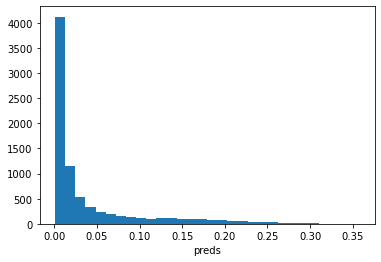

In [408]:
preds.std(dim='split').preds.plot.hist(bins=30)
plt.show()

In [409]:
pred_mean = preds.preds.mean(dim='split')
pred_median = xr.apply_ufunc(np.median, preds.preds,  input_core_dims=[['split']], kwargs={"axis": -1})

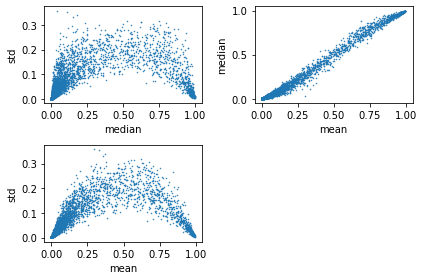

In [410]:
fig, axes = plt.subplots(2,2)

axes[0,0].plot(
    pred_median.values.flatten(), #submission.values.flatten(),
    preds.std(dim='split').preds.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[0,0].set_xlabel('median')
axes[0,0].set_ylabel('std')


axes[1,0].plot(
    pred_mean.values.flatten(),
    preds.std(dim='split').preds.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[1,0].set_xlabel('mean')
axes[1,0].set_ylabel('std')

axes[0,1].plot(
    pred_mean.values.flatten(),
    pred_median.values.flatten(), 
    linestyle='',
    marker='.',
    markersize=1
)
axes[0,1].set_xlabel('mean')
axes[0,1].set_ylabel('median')


axes[1,1].axis("off")
plt.tight_layout()
plt.show()

In [411]:
df = pred_mean.to_dataframe().unstack()
df.columns = df.columns.droplevel(None)
df.columns.name=None
df

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.026767,0.049370,0.022144,0.020320,0.001536,0.007072,0.021072,0.156165,0.016366,0.001812
S0767,0.096299,0.014730,0.008366,0.015353,0.001286,0.012890,0.193479,0.527362,0.043957,0.001494
S0768,0.323684,0.453182,0.007108,0.094888,0.001439,0.010862,0.612312,0.397197,0.007397,0.001378
S0769,0.018022,0.046565,0.118330,0.340028,0.001876,0.911080,0.032936,0.024908,0.703231,0.008655
S0770,0.006699,0.009154,0.022344,0.268511,0.001212,0.985839,0.972443,0.006203,0.009879,0.000964
...,...,...,...,...,...,...,...,...,...,...
S1565,0.130301,0.446064,0.157430,0.174701,0.469740,0.114632,0.208567,0.136880,0.119966,0.095763
S1566,0.156410,0.129566,0.082876,0.008868,0.001663,0.005971,0.063630,0.033664,0.043929,0.033951
S1567,0.008037,0.229324,0.013013,0.006910,0.002656,0.017491,0.320801,0.006548,0.081594,0.008405


In [412]:
df.to_csv('submission.csv')